# Physics 494/594
## Backpropagation: Training Neural Networks

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s.set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Last Time

### [Notebook Link: 15_Gradient_Neural_Network.ipynb](./15_Gradient_Neural_Network.ipynb)

- Taking the gradient of a neural network.

## Today

- Combine feed forward with backpropagation for supervised learning
- Training our deep neural network to *learn* a 2D shape

Let us recall our general network structure.  Previously we had randomly set the weights and biases and haven't actually used our deep neural networks for anything useful.

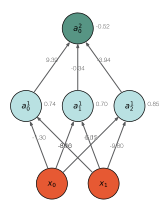

In [2]:
n = [2,3,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-10,high=10,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))
                
ml4s.draw_network(n, weights=w, biases=b)

### Feed Forward

For a given non-linearity (i.e. the sigmoid):

\begin{equation}
f(z) \equiv \sigma(z) = \frac{1}{1+\mathrm{e}^{-z}}
\end{equation}

we can evaluate the output of the network, $a_0^L$ here, by computing:

\begin{equation}
    z_j^\ell = \sum_{k=0}^{n_{\ell-1}-1} a_k^{\ell-1} w_{kj}^\ell + b_j^\ell 
\end{equation}

or in vector form

\begin{equation}
\mathbf{z}^\ell = \mathbf{a}^{\ell-1} \cdot \mathbf{w}^\ell + \mathbf{b}^\ell
\end{equation}

where $a_j^\ell = f(z_j^\ell)$ and $n_{\ell}$ is the number of neurons in layer $\ell$.  We previously programmed this up as follows:

In [3]:
def feed_forward_simple(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b). '''
    a = aₒ
    for wℓ,bℓ in zip(w,b):
        z = np.dot(a,wℓ) + bℓ
        
        # using a sigmoid for non-linearity
        a = 1.0/(1.0+np.exp(-z))
    return a

As before, let's plot the result (for random weights and biases) for all points (our batch) in the plane.

In [4]:
# number of grid-points in the xₒ and x₁ directions.
grid_size = 41 
X = np.meshgrid(np.linspace(-3,3,grid_size),np.linspace(-3,3,grid_size), indexing='xy')
extent = [np.min(X[0]),np.max(X[0]),np.min(X[1]),np.max(X[1])]

batch_size = grid_size**2
aₒ = np.zeros([batch_size,2])

aₒ[:,0] = X[0].flatten()
aₒ[:,1] = X[1].flatten()

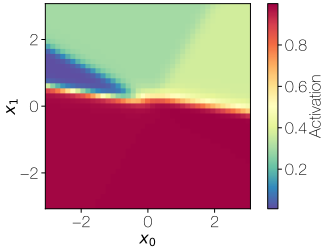

In [5]:
a2 = feed_forward_simple(aₒ,w,b).reshape(grid_size,grid_size) # reshape for plotting

plt.pcolormesh(*X,a2, shading='nearest', cmap='Spectral_r', rasterized=True)
plt.colorbar(label='Activation')
plt.gca().set_aspect('equal')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$');

### Backpropagation: Training our Network to Reproduce Desired Targets

In class we derived the fundamental equations of the backpropagation algorithm for a quadratic least-squares cost-function by introducing the *error* $\Delta$ at each layer $\ell$ and neuron $j$:

\begin{equation}
    \Delta_j^\ell \equiv \frac{\partial{C}}{\partial z_j^\ell}
    \label{eq:Delta}
\end{equation}

\begin{align}
            \Delta_j^L &= (a_j^L- y_j)\ f^\prime(z_j^L) & \ell=L \\
            \Delta_j^\ell &= \sum_k \Delta_k^{\ell+1} \left[{w^{\ell+1}}^{\mathsf{T}}\right]_{kj}\ f^\prime (z_j^\ell) & \ell < L
\end{align}

such that the gradients are given by:

\begin{align}
\frac{\partial{C}}{\partial w^\ell_{ij}} &= a_i^{\ell-1}\Delta_j^\ell \\
\frac{\partial{C}}{\partial b^\ell_{j}} &= \Delta_j^\ell
\end{align}

so we can perform a stochastic gradient descent (SGD) update:

\begin{align}
w^\ell_{ij} &\leftarrow w^\ell_{ij} -  \eta\langle a_i^{\ell-1}\Delta_j^\ell \rangle \\ 
b_j^\ell &\leftarrow b_j^\ell - \eta\langle \Delta_j^\ell \rangle 
\end{align}

where $\langle \dots \rangle$ indicates a mini-batch average.  Our algorithm thus proceeds as follows:

1. Feed input vector $a_0$ into our neural network.
2. Feedforward by computing $\mathbf{z}^\ell$ and $\mathbf{a}^\ell$ for $\ell = 1,\ldots,L$. We can also store $f'(\mathbf{z}^\ell)$ here.
3. Compute the error $\mathbf{\Delta}^L$ at the output layer.
4. Backpropagate the error and evaluate $\mathbf{\Delta}^\ell$ at all layers $\ell = L-1,\ldots,1$.
5. Compute gradient values, averaged over mini-batch.
6. Update $\mathbf{w}$ and $\mathbf{b}$ via SGD.

Let's start to collect the functions we will use for backpropagation.  

We need $f(z)$ and $f'(z)$.  Let's continue with our sigmoid for now

\begin{align}
f(z) &= \sigma(z) = \frac{1}{1 + \mathrm{e}^{-z}} \\
f'(z) &= \frac{\mathrm{e}^{-z}}{(1 + \mathrm{e}^{-z})^2}\, .
\end{align}

In [6]:
def ffprime(z): 
    '''calculate f(z) and f'(z); sigmoid.'''
    _f = 1.0/(1.0+np.exp(-z))
    return _f,np.exp(-z)*(_f**2)

#### Feed Forward
Now we want to adapt our `feed_forward_simple` above to store the value of $\mathbf{a}^\ell$ and $f'(\mathbf{z}^\ell)$ for each layer.

In [7]:
def feed_forward(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b).
       
       Return: activations (a) and derivatives f'(z) for each layer.'''
    
    a,df = [aₒ],[]
    
    for wℓ,bℓ in zip(w,b):
        zℓ = np.dot(a[-1],wℓ) + bℓ
        _a,_df = ffprime(zℓ)
        a.append(_a)
        df.append(_df)
        
    return a,df

#### Backpropagation

The tricky thing here is that we are moving backward (can do this with `range(L,-1,-1)` but we need to realize that there is one extra layer for the activations since $x \equiv a^0$ as opposed to the weights and biases. 

In [8]:
def backpropagation(y,a,w,b,df): 
    '''Inputs: results of a forward pass
       Targets     y: dim(y)  = batch_size ⨯ nL
       Activations a: dim(a)  = L ⨯ batch_size ⨯ nℓ
       Weights     w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases      b: dim(b)  = L-1 ⨯ nℓ
       f'(z)      df: dim(df) = L-1 ⨯ batch_size ⨯ nℓ
       
       Outputs: returns mini-batch averaged gradients of the cost function w.r.t. w and b
       dC_dw: dim(dC_dw) = dim(w)
       dC_db: dim(dC_db) = dim(b)
    '''
    
    batch_size = len(y)
    num_layers = len(w)
    L = num_layers-1        
    
    # initialize empty lists to store the derivatives of the cost functions
    dC_dw = [None]*num_layers
    dC_db = [None]*num_layers
    Δ = [None]*num_layers
    
    # perform the backpropagation
    for ℓ in range(L,-1,-1):
        
        # treat the last (output) layer differently
        if ℓ == L:
            Δ[ℓ] = (a[ℓ] - y)*df[ℓ]
        else: 
            Δ[ℓ] = (Δ[ℓ+1] @ w[ℓ+1].T) * df[ℓ]
            
        dC_dw[ℓ] = (a[ℓ-1].T @ Δ[ℓ]) / batch_size
        dC_db[ℓ] = np.average(Δ[ℓ],axis=0)
        
    return dC_dw,dC_db

In [9]:
def gradient_step(η,w,b,dC_dw,dC_db):
    '''Update the weights and biases as per gradient descent.'''
    
    for ℓ in range(len(w)):
        w[ℓ] -= η*dC_dw[ℓ]
        b[ℓ] -= η*dC_db[ℓ]
    return w,b

In [10]:
def train_network(x,y,w,b,η):
    '''Train a deep neural network via feed forward and back propagation.
       Inputs:
       Input         x: dim(x) = batch_size ⨯ n₁
       Target        y: dim(y) = batch_size ⨯ nL
       Weights       w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases        b: dim(b)  = L-1 ⨯ nℓ
       Learning rate η
       
       Outputs: the least squared cost between the network output and the targets.
       '''
    
    a,df = feed_forward(x,w,b)
    
    # we pass a cycled by 1 layer for ease of indexing (i.e. use a[-1] to get inputs)
    dC_dw,dC_db = backpropagation(y,a[1:]+[a[0]],w,b,df)
    
    w,b = gradient_step(η,w,b,dC_dw,dC_db)
    
    return 0.5*np.average((y-a[-1])**2)

### Let's train our network for some random targets

We begin by defining the network topology and randomly initializing the weights and biases.

In [11]:
n = [2,2,3,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-1,high=1,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))

#### Random inputs and outputs

As we are just checking our backpropagation algorithm, we randomly define the inputs and outputs.

In [12]:
batch_size = 100
η = 0.9
x = np.random.uniform(low=-1,high=+1,size=[batch_size,n[0]])
y = np.random.uniform(low=-1,high=+1,size=[batch_size,n[-1]])

#### Perform an iteration (feed forward + backpropagation)

In [13]:
cost = train_network(x,y,w,b,η)
print(f'C = {cost}')

C = 0.4229455440452219


#### Now we iterate over a number of mini-batches

We store the cost at each step and plot the result.

Text(0, 0.5, 'Cost')

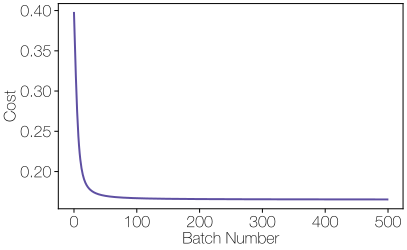

In [14]:
num_batches = 500
costs = np.zeros(num_batches)

for k in range(num_batches):
    costs[k] = train_network(x,y,w,b,η)
    
plt.plot(costs)
plt.xlabel('Batch Number')
plt.ylabel('Cost')

<div class="span alert alert-warning">
    The cost quickly plateaus as we are always using the same batch of inputs for each iteration.
</div>

## Function Fitting in the 2D Plane

Let's consider a more interesting example.  A modified version of the `AND` function you studied on the assignment.

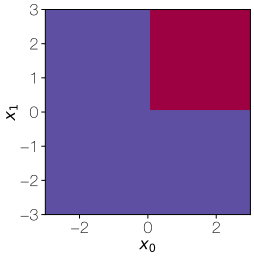

In [15]:
def AND(x,y):
    return (x>0)*(y>0)

plt.imshow(AND(*X), extent=extent, cmap='Spectral_r', rasterized=True, 
           interpolation='nearest', origin='lower', aspect='equal')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$');

#### Initializing the Neural Network

In [16]:
n = [2,25,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-1,high=1,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))

#### Feeding forward with our random weights and biases

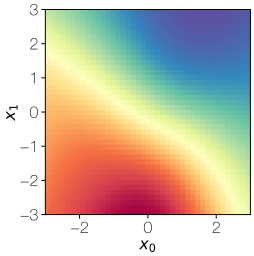

In [17]:
aL = feed_forward_simple(aₒ,w,b).reshape(grid_size,grid_size)
plt.imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
           interpolation='nearest', origin='lower', aspect='equal')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$');

#### Making Batches

We want to provide random inputs and targets for our SGD procedure.

In [18]:
def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n         : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    # n[0] is the input dimension nₒ
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=extent[2*i],high=extent[2*i+1],size=[batch_size])

    # we expand the final axis such that y is a matrix (and not a vector)
    y = func(*[x[:,j] for j in range(n[0])])[:,np.newaxis]
    
    return x,y 

Text(0, 0.5, 'Cost')

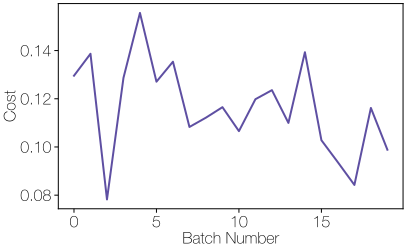

In [19]:
η = 0.9
batch_size = 100
num_batches = 20
costs = np.zeros(num_batches)

for k in range(num_batches):
    x,y = make_batch(n,batch_size,extent,AND)

    costs[k] = train_network(x,y,w,b,η)
    
plt.plot(costs)
plt.xlabel('Batch Number')
plt.ylabel('Cost')

### Output the result of the neural network

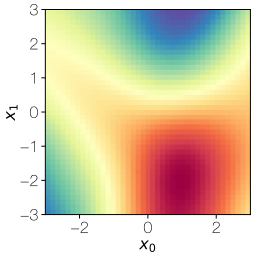

In [20]:
aL = feed_forward_simple(aₒ,w,b).reshape(X[0].shape)
plt.imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
           interpolation='nearest', origin='lower', aspect='equal')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$');

### Watch the Learning Process Happen in Real Time

#### Initialize the Network


<!-- Ideal parameters:

def ffprime(z): 
    '''calculate f(z) and f'(z); relu.'''
    _f = z*(z>0)
    return _f,z>0

# reLU
n = [2,25,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-1.0,high=1.0,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))

η = 0.9
batch_size = 1000
num_steps = 10000
-->

In [21]:
n = [2,3,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-1,high=1,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))

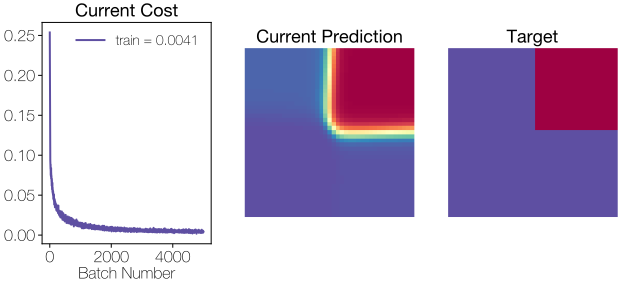

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1198.64it/s]


In [22]:
from IPython.display import clear_output,display
from time import sleep
η = 0.9

batch_size = 500
num_steps = 5000
plot_ratio = int(num_steps / 50)

costs = np.zeros(num_steps)
for j in trange(num_steps):
    
    x,y = make_batch(n,batch_size,extent,AND)
    costs[j] = train_network(x,y,w,b,η)
    
    # we plot every plot_ratio steps
    if not j % plot_ratio or j == num_steps-1:
        aL = feed_forward_simple(aₒ,w,b).reshape(X[0].shape)
        fig,ax = ml4s.plot_training_2D(aL,AND(*X),costs)

#### That is it! You have written and trained your first deep neural network!

Things to think about:

1. What happens if you change the non-linearity?
2. How sensitive is it to the initial weights and biases?
3. What are the effects of changing the hyper-parameters (e.g. batch_size, η) 
4. Does it work for all network topologies?











